# **Классификатор интентов**

Импортируем данные.

In [1]:
!unzip /content/task-specific-datasets-master.zip

Archive:  /content/task-specific-datasets-master.zip
f1fa11776b7a016eef3dabd417017e11c5144986
   creating: task-specific-datasets-master/
  inflating: task-specific-datasets-master/LICENSE  
  inflating: task-specific-datasets-master/README.md  
   creating: task-specific-datasets-master/banking_data/
  inflating: task-specific-datasets-master/banking_data/categories.json  
  inflating: task-specific-datasets-master/banking_data/test.csv  
  inflating: task-specific-datasets-master/banking_data/train.csv  
  inflating: task-specific-datasets-master/polyai-logo.png  
   creating: task-specific-datasets-master/span_extraction/
   creating: task-specific-datasets-master/span_extraction/dstc8/
   creating: task-specific-datasets-master/span_extraction/dstc8/Buses_1/
  inflating: task-specific-datasets-master/span_extraction/dstc8/Buses_1/test.json  
  inflating: task-specific-datasets-master/span_extraction/dstc8/Buses_1/train_0.json  
  inflating: task-specific-datasets-master/span_extrac

In [2]:
import pandas as pd
import json

In [3]:
train = pd.read_csv('/content/task-specific-datasets-master/banking_data/train.csv')
test = pd.read_csv('/content/task-specific-datasets-master/banking_data/test.csv')

In [4]:
with open("/content/task-specific-datasets-master/banking_data/categories.json", "r") as read_file:
    cats = json.load(read_file)

In [ ]:
train.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


Присвоим категориям номера.

In [6]:
train['label'] = 0
for i in range(len(train)):
  train['label'][i] = cats.index(train.category[i])
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,category,label
0,I am still waiting on my card?,card_arrival,0
1,What can I do if my card still hasn't arrived ...,card_arrival,0
2,I have been waiting over a week. Is the card s...,card_arrival,0
3,Can I track my card while it is in the process...,card_arrival,0
4,"How do I know if I will get my card, or if it ...",card_arrival,0
...,...,...,...
9998,You provide support in what countries?,country_support,76
9999,What countries are you supporting?,country_support,76
10000,What countries are getting support?,country_support,76
10001,Are cards available in the EU?,country_support,76


In [7]:
test['label'] = 0
for i in range(len(test)):
  test['label'][i] = cats.index(test.category[i])
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,category,label
0,How do I locate my card?,card_arrival,0
1,"I still have not received my new card, I order...",card_arrival,0
2,I ordered a card but it has not arrived. Help ...,card_arrival,0
3,Is there a way to know when my card will arrive?,card_arrival,0
4,My card has not arrived yet.,card_arrival,0
...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,76
3076,How many countries do you support?,country_support,76
3077,What countries do you do business in?,country_support,76
3078,What are the countries you operate in.,country_support,76


In [8]:
train.groupby('category').count()['label'].values

array([162, 159, 110, 126,  87, 127, 171, 181, 156, 157, 129,  59, 153,
       112, 139, 112, 187, 168, 167,  61, 177, 160, 122,  86,  35, 129,
       153, 173, 133, 182, 121, 121, 121, 112, 118, 166, 137, 126,  97,
       106, 129,  98,  82, 121, 120, 105, 159, 143, 149, 148, 115,  95,
       169, 161, 129, 108, 111, 114, 114, 145,  97, 146, 103, 175, 172,
       113, 171, 128, 102, 104, 113, 126,  41, 135, 121, 180, 163])

Значительного дисбаланса классов не наблюдается, однако все равно есть очень малонаполненные категории. 

## **Логистическая регрессия на векторах Tf-idf**

Сделаем небольшой препроцессинг текста и обучим логистическую регрессию на векторах tf-idf.

In [9]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [10]:
x_train, y_train = train['text'], train['label']
x_test, y_test = test['text'], test['label']

In [11]:
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

noise = list(string.punctuation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [13]:
from sklearn.metrics import f1_score

In [14]:
def process_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text.lower()) if word not in noise])

In [153]:
x_train.apply(process_text)

0                              am still waiting on my card
1             if my card still ha n't arrived after 2 week
2        have been waiting over a week is the card stil...
3        track my card while it is in the process of de...
4            how know if will get my card or if it is lost
                               ...                        
9998                        you provide support in country
9999                            country are you supporting
10000                          country are getting support
10001                         are card available in the eu
10002                        which country are represented
Name: text, Length: 10003, dtype: object

In [15]:
tfidf_vec = TfidfVectorizer(max_features=5000)
tr_vect = tfidf_vec.fit_transform(x_train.apply(process_text))
ts_vect = tfidf_vec.transform(x_test.apply(process_text))

In [16]:
model = LogisticRegression(class_weight='balanced')
model.fit(tr_vect, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
preds = model.predict(ts_vect)

In [18]:
f1_score(y_test, preds, average='macro')

0.8849238817446518

При подборе гиперпараметров лучшее качество, которое удалось достигнуть: **0.885**. Удаление стоп-слов при препроцессинге снизило качество, поэтому мы решили оставить только очистку от знаков препинания и лемматизацию. Также пробовалась векторизация с помощью модели word2vec, но она показала более плохое качество.

Теперь попробуем провести стемминг текстов, а не лемматизировать.

In [48]:
from nltk.stem.snowball import SnowballStemmer

In [60]:
st = SnowballStemmer('english')
def stem_text(text):
    return ' '.join([st.stem(word) for word in word_tokenize(text.lower()) if word not in noise])

In [182]:
tfidf_vec2 = TfidfVectorizer(max_features=1500)
tr_st = tfidf_vec2.fit_transform(x_train.apply(stem_text))
ts_st = tfidf_vec2.transform(x_test.apply(stem_text))
model = LogisticRegression(class_weight='balanced')
model.fit(tr_st, y_train)
prs = model.predict(ts_st)

In [194]:
x_test.apply(stem_text)

0                                  how do i locat my card
1       i still have not receiv my new card i order ov...
2          i order a card but it has not arriv help pleas
3          is there a way to know when my card will arriv
4                               my card has not arriv yet
                              ...                        
3075         if i 'm not in the uk can i still get a card
3076                      how mani countri do you support
3077                       what countri do you do busi in
3078                     what are the countri you oper in
3079                can the card be mail and use in europ
Name: text, Length: 3080, dtype: object

In [109]:
f1_score(y_test, prs, average='macro')

0.8905673434287157

Хоть качество выросло и незначительно, все же стемминг улучшил модель.

Создадим график для возможной визуализации результатов.

In [215]:
import matplotlib.pyplot as plt

def plot_classification_report(cr, title='Отчет по классификации', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []

    for line in lines[2 : 10]: # для простоты восприятия взяла 8 категорий

        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Классы')
    plt.xlabel('Метрики')

[0.86, 0.8, 0.83]
[0.95, 1.0, 0.98]
[0.85, 0.97, 0.91]
[0.94, 0.85, 0.89]
[0.76, 0.85, 0.8]
[0.97, 0.88, 0.92]
[0.97, 0.75, 0.85]
[0.88, 0.93, 0.9]


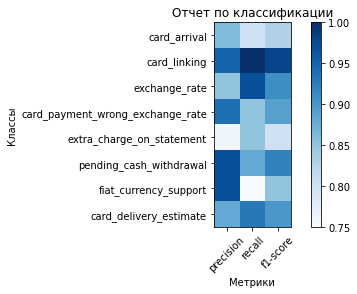

In [216]:
from sklearn.metrics import classification_report
classificationReport = classification_report(y_test, prs, target_names=cats)

plot_classification_report(classificationReport)

В таком виде мы можем посмотреть на качество предсказания каждого класса, однако классов слишком много для общей визуализации таблицы. Но мы можем выводить конкретно те, что нам нужны и таким образом отследить, в каком классе качество оказалось наиболее низким.

## **Random Forest Classifier**

Попробуем также обучить рандомный лес, хотя он более неустойчив к дисбалансу классов.

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
fore = RandomForestClassifier(n_estimators=300, max_depth=50)
fore.fit(tr_st, y_train)
f1_score(y_test, fore.predict(ts_st), average='macro')

0.8821842739545784

Благодаря подбору гиперпараметров через GridSearch, лучшее качество, которое нам удалось достичь, все же ниже, чем обычная логистическая регрессия, однако разница не такая большая.

In [121]:
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
parameters = {'n_estimators': [200, 300, 500], 'max_depth': [30, 40, 50], 'min_samples_leaf': [1, 2, 3, 5]}
cv = GridSearchCV(fore, parameters)
cv.fit(tr_vect, y_train)

## **Наивный байесовский классификатор**

Классификатор показывает худшее качество, чем предыдущие модели.

In [107]:
from sklearn.naive_bayes import MultinomialNB

model_naive = MultinomialNB().fit(tr_vect, y_train) 
predicted_naive = model_naive.predict(ts_vect)

In [110]:
precision_recall_fscore_support(y_test, predicted_naive, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.816070560946902, 0.7883116883116883, 0.7737913019349892, None)

## **BERT**

Теперь попробуем воспользоваться более сложными моделями, а именно применить трансформеры и посмотреть, улучшится ли качество предсказания. Мы модифицировали бейзлайн с Kaggle под нашу задачу.

In [88]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 8.4MB/s 
     |████████████████████████████████| 901kB 15.7MB/s 
     |████████████████████████████████| 133kB 26.6MB/s 
     |████████████████████████████████| 1.2MB 22.2MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 7.5MB 42.3MB/s 
ERROR: botocore 1.20.69 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [89]:
import random
import numpy as np
import os
import torch
import torch.nn as nn
from pytorch_transformers import BertModel, BertTokenizer, BertConfig, WarmupLinearSchedule
import re
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm, trange

def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [120]:
SEP_TOKEN = '[SEP]'
CLS_TOKEN = '[CLS]'
TRAIN_FILE_PATH = '/content/task-specific-datasets-master/banking_data/train.csv'
MAX_SEQ_LENGTH = 450
BATCH_SIZE = 4
NUM_EPOCHS = 10
GRADIENT_ACCUMULATION_STEPS = 8
WARMUP_STEPS = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [121]:
class BertClassifier(nn.Module):

    def __init__(self, config):
        super(BertClassifier, self).__init__()
        
        self.num_labels = config.num_labels
        
        self.bert = BertModel(config)
        
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None,
                position_ids=None, head_mask=None):
        
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        
        
        pooled_output = outputs[-1]

        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [122]:
class SequenceDataset(Dataset):
    def __init__(self, dataset_file_path, tokenizer, regex_transformations={}):
        

        df = pd.read_csv(dataset_file_path)
        self.headlines = df.values
        self.regex_transformations = regex_transformations
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, index):
        headline, label = self.headlines[index][0], cats.index(self.headlines[index][1])
        for regex, value_to_replace_with in self.regex_transformations.items():
            headline = re.sub(regex, value_to_replace_with, headline)
        tokens = self.tokenizer.tokenize(headline)

        tokens = [CLS_TOKEN] + tokens + [SEP_TOKEN]

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        segment_ids = [0] * len(input_ids)

        input_mask = [1] * len(input_ids)

        padding_length = MAX_SEQ_LENGTH - len(input_ids)
        input_ids = input_ids + [0] * padding_length
        input_mask = input_mask + [0] * padding_length
        segment_ids = segment_ids + [0] * padding_length

        assert len(input_ids) == MAX_SEQ_LENGTH
        assert len(input_mask) == MAX_SEQ_LENGTH
        assert len(segment_ids) == MAX_SEQ_LENGTH

        return torch.tensor(input_ids, dtype=torch.long, device=DEVICE), \
               torch.tensor(segment_ids, dtype=torch.long, device=DEVICE), \
               torch.tensor(input_mask, device=DEVICE), \
               torch.tensor(label, dtype=torch.long, device=DEVICE)

In [123]:
config = BertConfig(hidden_size=384,
                    num_hidden_layers=12,
                    num_attention_heads=12,
                    intermediate_size=3072,
                    num_labels=len(cats))

model = BertClassifier(config)
model.to(DEVICE)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 1191150.21B/s]


In [124]:
train_dataset = SequenceDataset(TRAIN_FILE_PATH, tokenizer)

validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True

if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=validation_sampler)

print ('Training Set Size {}, Validation Set Size {}'.format(len(train_indices), len(val_indices))) # будет удобнее наблюдать за процессом обучения

Training Set Size 8003, Validation Set Size 2000


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
                {'params': model.bert.parameters(), 'lr' : 1e-5},
                {'params': model.classifier.parameters(), 'lr': 3e-4}
            ])


scheduler = WarmupLinearSchedule(optimizer, warmup_steps=WARMUP_STEPS, t_total=len(train_loader) // GRADIENT_ACCUMULATION_STEPS * NUM_EPOCHS)

model.zero_grad()
epoch_iterator = trange(int(NUM_EPOCHS), desc="Epoch")
training_acc_list, validation_acc_list = [], []

In [126]:
for epoch in epoch_iterator:
    epoch_loss = 0.0
    train_correct_total = 0

    train_iterator = tqdm(train_loader, desc="Train Iteration")
    for step, batch in enumerate(train_iterator):
        model.train(True)

        inputs = {
            'input_ids': batch[0].to(DEVICE),
            'token_type_ids': batch[1].to(DEVICE),
            'attention_mask': batch[2].to(DEVICE)
        }

        labels = batch[3].to(DEVICE)
        logits = model(**inputs)

        loss = criterion(logits, labels) / GRADIENT_ACCUMULATION_STEPS
        loss.backward()
        epoch_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            scheduler.step()
            optimizer.step()
            model.zero_grad()

        _, predicted = torch.max(logits.data, 1)
        correct_reviews_in_batch = (predicted == labels).sum().item()
        train_correct_total += correct_reviews_in_batch
    
    print('Epoch {} - Loss {:.2f}'.format(epoch + 1, epoch_loss / len(train_indices)))

    with torch.no_grad():
        val_correct_total = 0
        model.train(False)
        val_iterator = tqdm(val_loader, desc="Validation Iteration")
        for step, batch in enumerate(val_iterator):
            inputs = {
                'input_ids': batch[0].to(DEVICE),
                'token_type_ids': batch[1].to(DEVICE),
                'attention_mask': batch[2].to(DEVICE)
            }

            labels = batch[3].to(DEVICE)
            logits = model(**inputs)

            _, predicted = torch.max(logits.data, 1)
            correct_reviews_in_batch = (predicted == labels).sum().item()
            val_correct_total += correct_reviews_in_batch

        training_acc_list.append(train_correct_total * 100 / len(train_indices))
        validation_acc_list.append(val_correct_total * 100 / len(val_indices))
        print('Training Accuracy {:.4f} - Validation Accurracy {:.4f}'.format(train_correct_total * 100 / len(train_indices), val_correct_total * 100 / len(val_indices)))        

Validation Iteration:   0%|          | 2/500 [00:00<00:40, 12.44it/s]

Epoch 1 - Loss 0.03


Train Iteration:   0%|          | 0/2001 [00:00<?, ?it/s]

Training Accuracy 75.1593 - Validation Accurracy 76.6500


Validation Iteration:   0%|          | 2/500 [00:00<00:39, 12.51it/s]

Epoch 2 - Loss 0.03


Train Iteration:   0%|          | 0/2001 [00:00<?, ?it/s]

Training Accuracy 75.7591 - Validation Accurracy 76.6500


Validation Iteration:   0%|          | 2/500 [00:00<00:39, 12.50it/s]

Epoch 3 - Loss 0.03


Train Iteration:   0%|          | 0/2001 [00:00<?, ?it/s]

Training Accuracy 75.4092 - Validation Accurracy 76.6500


Validation Iteration:   0%|          | 2/500 [00:00<00:39, 12.57it/s]

Epoch 4 - Loss 0.03


Train Iteration:   0%|          | 0/2001 [00:00<?, ?it/s]

Training Accuracy 75.3842 - Validation Accurracy 76.6500


Validation Iteration:   0%|          | 2/500 [00:00<00:39, 12.64it/s]

Epoch 5 - Loss 0.03


Train Iteration:   0%|          | 0/2001 [00:00<?, ?it/s]

Training Accuracy 75.8091 - Validation Accurracy 76.6500


Validation Iteration:   0%|          | 2/500 [00:00<00:39, 12.47it/s]

Epoch 6 - Loss 0.03


Train Iteration:   0%|          | 0/2001 [00:00<?, ?it/s]

Training Accuracy 75.6591 - Validation Accurracy 76.6500


Validation Iteration:   0%|          | 2/500 [00:00<00:39, 12.57it/s]

Epoch 7 - Loss 0.03


Train Iteration:   0%|          | 0/2001 [00:00<?, ?it/s]

Training Accuracy 75.8091 - Validation Accurracy 76.6500


Train Iteration:  21%|██        | 415/2001 [01:34<05:56,  4.45it/s]

KeyboardInterrupt: ignored

In [60]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(real, pred, average='micro')

(0.7185064935064935, 0.7185064935064935, 0.7185064935064934, None)

Трансформеры на данном этапе показывают худшее качество классификации, однако, улучшив их и увеличив количество эпох (изменив и другие гиперпараметры), возможно забустить модель на качество выше 0.9.

# **Реализация Self-adjusting Dice Loss**

In [61]:
class SelfAdjDiceLoss(torch.nn.Module):

    def __init__(self, gamma=1.0, reduction="mean"):
        
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, preds, targets) -> torch.Tensor:

        probs = torch.gather(torch.softmax(preds, dim=1), dim=1, index=targets.unsqueeze(1))
        
        loss = 1 - (2 * (1 - probs) * probs + self.gamma) / ((1 - probs) * probs + 1 + self.gamma)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "none":
            return loss

Данная функция потерь как раз учитывает дисбаланс классов и по сути обучает не на accuracy, а на f1-меру.

# **Сэмплирование батчей в несбалансированных выборках**

В задачах текстовой классификации используются несколько способов бороться с дисбалансом в данных, и часть из них основана на механизмах сэмплирования.

* Мы можем использовать **Random Oversampling**, суть которого заключается в том, что мы просто увеличиваем выборку путем копирования сэмплов из малочисленного класса (объекты из них выбираются рандомно). 
* **SMOTE** - создаются синтетические сэмплы при помощи kNN. 
* Другие реализации SMOTE, как **SMOTE-SVM**, **WEMOTE** и т. д.

Реализуем SMOTE, который уже в экспериментах показал хорошие результаты (имплементация частично бралась с непопулярного гитхаба, но из комментариев все должно быть ясно). 

Статья: https://arxiv.org/pdf/1106.1813.pdf 

In [170]:
class SMOTE(object):

    def __init__(self, distance='euclidian', dims=512, k=5):
        
        super(SMOTE,self).__init__()
        self.newindex = 0 
        self.k = k
        self.dims = dims
        self.distance_measure = distance
        
    def populate(self, N, i, nnarray, min_samples, k):
        
        # собственно, создание синтетических сэмплов, исходя из полноты класса (N), конкретного объекта с индексом i из
        # всех индексов объектов данного класса (nnarray), k ближайших соседей (может рассчитываться только исходя из общего кол-ва объектов)
        # и собственно всех объектов классa min_samples
        while N:
            
            nn = randint(0, k-2)
            
            diff = min_samples[nnarray[nn]] - min_samples[i]
            gap = random.uniform(0,1)

            self.synthetic_arr[self.newindex, :] = min_samples[i] + gap * diff
            
            self.newindex += 1
            
            N -= 1

    def k_neighbors(self, euclid_distance, k):
        
        # вывод индексов ближайших соседей
        nearest_idx = torch.zeros((euclid_distance.shape[0], euclid_distance.shape[0]), dtype = torch.int64)
        idxs = torch.argsort(euclid_distance, dim=1)
        nearest_idx[:, :] = idxs
        
        return nearest_idx[:, 1:k]
    
    def find_k(self, X, k):

        euclid_distance = torch.zeros((X.shape[0], X.shape[0]), dtype = torch.float32)
        # создаем матрицу расстояний между объектами, чтобы найти k ближайших соседей, опираясь на нее
        for i in range(len(X)):
            dif = (X - X[i])**2
            dist = torch.sqrt(dif.sum(axis=1))
            euclid_distance[i] = dist
            
        return self.k_neighbors(euclid_distance, k)
    
    def generate(self, min_samples, N, k):
      # общий алгоритм генерации для одного класса

        T = min_samples.shape[0]
        self.synthetic_arr = torch.zeros(int(N / 100) * T, self.dims)
        N = int(N / 100)
        if self.distance_measure == 'euclidian':
            indices = self.find_k(min_samples, k)
        
        for i in range(indices.shape[0]):
            self.populate(N, i, indices[i], min_samples, k)
        
        self.newindex = 0 

        return self.synthetic_arr
            
    def fit_generate(self, X, y):
      # для всех классов, кроме доминирующего делаем сэмплирование по алгоритму на основе их полноты

        occ = torch.eye(int(y.max() + 1), int(y.max() + 1))[y].sum(axis=0)

        dominant_class = torch.argmax(occ)
        n_occ = int(occ[dominant_class].item())

        for cat in range(len(occ)):
            if cat != dominant_class:
                N = (n_occ - occ[cat]) * 100 / occ[cat]
                candidates = X[train[train.label  == cat].index]
                xs = self.generate(candidates, N, self.k)
                X = torch.cat((X, xs))
                ys = torch.ones(xs.shape[0]) * cat
                y = torch.cat((y, ys))

        return X, y

# **Обертка классификатора в REST-сервис**

In [176]:
!pip install flask_restful

In [ ]:
from flask import Flask
from flask_restful import reqparse, abort, Api, Resource
import joblib
import nltk
import string
import numpy as np

app = Flask(__name__)
api = Api(app)

classifier = joblib.load('/content/classifier.pkl')
vectorizer = joblib.load('vectorizer.pkl')
st = nltk.stem.SnowballStemmer('english')

def stem_text(text):
    return ' '.join([st.stem(word) for word in nltk.word_tokenize(text.lower()) if word not in list(string.punctuation)])


class Classify(Resource):
    
    def post():

        parser = reqparse.RequestParser()
        parser.add_argument('text')

        args = parser.parse_args()
        text = args['text']

        tf_idf = vectorizer.transform([stem_text(text)])

        prediction = model.predict(tf_idf)

        output = {'prediction': cats[int(prediction)]}
        
        return output


api.add_resource(Classify, '/classify')

if __name__ == '__main__':
    app.run(debug=True, port='1080')